# jsb 논문 구현

## 라이브러리 로드

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError

## 데이터 로드 및 변환

In [2]:
import yaml

class CustomLoader(yaml.Loader):
    def __init__(self, stream):
        super(CustomLoader, self).__init__(stream)
        self.add_constructor('!obj:pylearn2.train.Train', self.construct_train)
        self.add_constructor('!obj:librnn.pylearn2.datasets.music.MusicSequence', self.construct_generic)
        self.add_constructor('!obj:pylearn2.sandbox.rnn.models.rnn.RNN', self.construct_generic)
        self.add_constructor('!obj:pylearn2.sandbox.rnn.models.rnn.GRU', self.construct_generic)
        self.add_constructor('!obj:librnn.pylearn2.models.mlp.Sigmoid', self.construct_generic)
        self.add_constructor('!obj:pylearn2.sandbox.rnn.space.SequenceDataSpace', self.construct_generic)
        self.add_constructor('!obj:pylearn2.space.VectorSpace', self.construct_generic)
        self.add_constructor('!obj:pylearn2.training_algorithms.sgd.SGD', self.construct_generic)
        self.add_constructor('!obj:librnn.pylearn2.training_algorithms.learning_rule.RMSPropMomentum', self.construct_generic)
        self.add_constructor('!obj:librnn.pylearn2.costs.rnn.RNNCost', self.construct_generic)
        self.add_constructor('!obj:pylearn2.termination_criteria.And', self.construct_generic)
        self.add_constructor('!obj:pylearn2.termination_criteria.EpochCounter', self.construct_generic)
        self.add_constructor('!obj:pylearn2.train_extensions.best_params.MonitorBasedSaveBest', self.construct_generic)
        self.add_constructor('!obj:pylearn2.training_algorithms.sgd.LinearDecayOverEpoch', self.construct_generic)

    def construct_train(self, loader, node):
        # YAML에서 `!obj:pylearn2.train.Train` 태그가 사용될 때 반환될 객체/데이터 정의
        # 여기서는 단순히 dict로 반환
        return loader.construct_mapping(node)

    def construct_generic(self, loader, node):
        # 다른 모든 커스텀 태그는 기본적으로 dict로 변환
        return loader.construct_mapping(node)



In [3]:
def load_data_with_custom_loader(yaml_file_path):
    with open(yaml_file_path, 'r') as file:
        try:
            data = yaml.load(file, Loader=CustomLoader)
        except yaml.YAMLError as e:
            print(f"Error parsing YAML: {e}")
            data = None
    return data

In [21]:
# YAML 파일 경로 설정
gru_yaml_path = 'gru.yaml'
lstm_yaml_path = 'lstm.yaml'

# 사용자 정의 로더로 YAML 파일 로드
gru_data = load_data_with_custom_loader(gru_yaml_path)
lstm_data = load_data_with_custom_loader(lstm_yaml_path)



In [22]:
# 로드된 데이터 출력 (필요 시)
print("GRU Data:", gru_data)

GRU Data: {'dataset': {'which_dataset': 'jsb', 'which_set': 'train'}, 'model': {'input_space': {'space': {'dim': 96}}, 'layers': [{'layer_name': 'h_1', 'dim': 48, 'irange': 0.1, 'weight_noise': 1}, {'layer_name': 'y', 'dim': 96, 'irange': 0.1}]}, 'algorithm': {'batch_size': 1, 'learning_rate': 0.001, 'learning_rule': {'init_momentum': 0.9, 'momentum_clipping': 1.0}, 'monitoring_dataset': {'train': {'which_dataset': 'jsb', 'which_set': 'train'}, 'valid': {'which_dataset': 'jsb', 'which_set': 'valid'}}, 'cost': {}, 'termination_criterion': {'criteria': [{'max_epochs': 500}]}}, 'extensions': [{'channel_name': 'valid_objective', 'save_path': 'gru_best.pkl'}, {'start': 1, 'saturate': 500, 'decay_factor': 0.01}], 'save_path': 'gru.pkl', 'save_freq': 10}


In [23]:
print("LSTM Data:", lstm_data)

LSTM Data: {'dataset': {'which_dataset': 'jsb', 'which_set': 'train'}, 'model': {'input_space': {'space': {'dim': 96}}, 'layers': [{'layer_name': 'h_1', 'dim': 36, 'irange': 0.1, 'weight_noise': 1}, {'layer_name': 'y', 'dim': 96, 'irange': 0.1}]}, 'algorithm': {'batch_size': 1, 'learning_rate': 0.001, 'learning_rule': {'init_momentum': 0.9, 'momentum_clipping': 1.0}, 'monitoring_dataset': {'train': {'which_dataset': 'jsb', 'which_set': 'train'}, 'valid': {'which_dataset': 'jsb', 'which_set': 'valid'}}, 'cost': {}, 'termination_criterion': {'criteria': [{'max_epochs': 500}]}}, 'extensions': [{'channel_name': 'valid_objective', 'save_path': 'lstm_best.pkl'}, {'start': 1, 'saturate': 500, 'decay_factor': 0.01}], 'save_path': 'lstm.pkl', 'save_freq': 10}


## 모델 세팅

In [5]:
# GRU 모델 구성
def build_gru_model(gru_data):
    input_dim = gru_data['model']['input_space']['space']['dim']
    gru_layer_info = gru_data['model']['layers'][0]
    output_dim = gru_data['model']['layers'][1]['dim']
    
    model = Sequential()
    model.add(GRU(gru_layer_info['dim'], 
                  input_shape=(None, input_dim),
                  return_sequences=True))
    model.add(Dense(output_dim, 
                    activation='linear'))  # 활성화 함수를 'linear'로 설정하여 회귀 모델로 구성

    # SGD 옵티마이저 사용
    optimizer = SGD(learning_rate=gru_data['algorithm']['learning_rate'], 
                    momentum=gru_data['algorithm']['learning_rule']['init_momentum'])

    model.compile(optimizer=optimizer, 
                  loss=MeanSquaredError(),
                  metrics=[MeanSquaredError()])
    return model


In [6]:
# LSTM 모델 구성
def build_lstm_model(lstm_data):
    input_dim = lstm_data['model']['input_space']['space']['dim']
    lstm_layer_info = lstm_data['model']['layers'][0]
    output_dim = lstm_data['model']['layers'][1]['dim']
    model = Sequential()
    model.add(LSTM(lstm_layer_info['dim'],
                   input_shape=(None, input_dim),
                   return_sequences=True))
    model.add(Dense(output_dim,
                    activation='linear'))  # 활성화 함수를 'linear'로 설정하여 회귀 모델로 구성

    # SGD 옵티마이저 사용
    optimizer = SGD(learning_rate=lstm_data['algorithm']['learning_rate'], 
                    momentum=lstm_data['algorithm']['learning_rule']['init_momentum'])

    model.compile(optimizer=optimizer, 
                  loss=MeanSquaredError(), 
                  metrics=[MeanSquaredError()])
    return model


In [7]:
# GRU 및 LSTM 모델 생성
gru_model = build_gru_model(gru_data)
lstm_model = build_lstm_model(lstm_data)


## 모델 구조 확인

In [8]:
# 모델 구조 확인
gru_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 48)          21024     
                                                                 
 dense (Dense)               (None, None, 96)          4704      
                                                                 
Total params: 25,728
Trainable params: 25,728
Non-trainable params: 0
_________________________________________________________________


In [9]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 36)          19152     
                                                                 
 dense_1 (Dense)             (None, None, 96)          3552      
                                                                 
Total params: 22,704
Trainable params: 22,704
Non-trainable params: 0
_________________________________________________________________


In [10]:

# 데이터 준비 (예시 데이터)
X_train = np.random.rand(1000, 10, 96)  # 예시 데이터
y_train = np.random.rand(1000, 10, 96)  # 예시 데이터
X_valid = np.random.rand(200, 10, 96)   # 예시 데이터
y_valid = np.random.rand(200, 10, 96)   # 예시 데이터


## 훈련

In [11]:
# GRU 모델 훈련
gru_model.fit(X_train, y_train, 
              batch_size=gru_data['algorithm']['batch_size'], 
              epochs=gru_data['algorithm']['termination_criterion']['criteria'][0]['max_epochs'], 
              validation_data=(X_valid, y_valid))



Epoch 1/500
1000/1000 [==============================] - 3s 2ms/step - loss: 0.1702 - mean_squared_error: 0.1702 - val_loss: 0.1021 - val_mean_squared_error: 0.1021
Epoch 2/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0987 - mean_squared_error: 0.0987 - val_loss: 0.0978 - val_mean_squared_error: 0.0978
Epoch 3/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0968 - mean_squared_error: 0.0968 - val_loss: 0.0965 - val_mean_squared_error: 0.0965
Epoch 4/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0953 - val_mean_squared_error: 0.0953
Epoch 5/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0945 - mean_squared_error: 0.0945 - val_loss: 0.0943 - val_mean_squared_error: 0.0943
Epoch 6/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0935 - mean_squared_error: 0.0935 - val_loss: 0.0934 - val_mean_squared_error: 0.0934
Epoch 7/50

In [12]:
# LSTM 모델 훈련
lstm_model.fit(X_train, y_train, 
               batch_size=lstm_data['algorithm']['batch_size'], 
               epochs=lstm_data['algorithm']['termination_criterion']['criteria'][0]['max_epochs'], 
               validation_data=(X_valid, y_valid))



Epoch 1/500
1000/1000 [==============================] - 4s 3ms/step - loss: 0.2031 - mean_squared_error: 0.2031 - val_loss: 0.1246 - val_mean_squared_error: 0.1246
Epoch 2/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1038 - mean_squared_error: 0.1038 - val_loss: 0.0948 - val_mean_squared_error: 0.0948
Epoch 3/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0929 - mean_squared_error: 0.0929 - val_loss: 0.0921 - val_mean_squared_error: 0.0921
Epoch 4/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0912 - val_mean_squared_error: 0.0912
Epoch 5/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0906 - val_mean_squared_error: 0.0906
Epoch 6/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0901 - val_mean_squared_error: 0.0901
Epoch 7/50

In [13]:
from sklearn.metrics import r2_score
import tensorflow as tf
import absl.logging
import warnings

tf.get_logger().setLevel('ERROR')
absl.logging.set_verbosity(absl.logging.ERROR)
warnings.filterwarnings('ignore')



In [14]:
# 모델 저장
gru_model.save(gru_data['save_path'])
lstm_model.save(lstm_data['save_path'])


In [15]:
# GRU 모델 예측 및 MSE, R² 계산
y_pred_gru = gru_model.predict(X_valid)
mse_gru = np.mean((y_valid - y_pred_gru) ** 2)
r2_gru = r2_score(y_valid.flatten(), y_pred_gru.flatten())

print(f"GRU Model - MSE: {mse_gru}, R²: {r2_gru}")

7/7 [==============================] - 0s 2ms/step
GRU Model - MSE: 0.08374511625215345, R²: -0.003365292725837188


In [16]:
# LSTM 모델 예측 및 MSE, R² 계산
y_pred_lstm = lstm_model.predict(X_valid)
mse_lstm = np.mean((y_valid - y_pred_lstm) ** 2)
r2_lstm = r2_score(y_valid.flatten(), y_pred_lstm.flatten())

print(f"LSTM Model - MSE: {mse_lstm}, R²: {r2_lstm}")

7/7 [==============================] - 0s 1ms/step
LSTM Model - MSE: 0.08369391332785273, R²: -0.002751821285010392


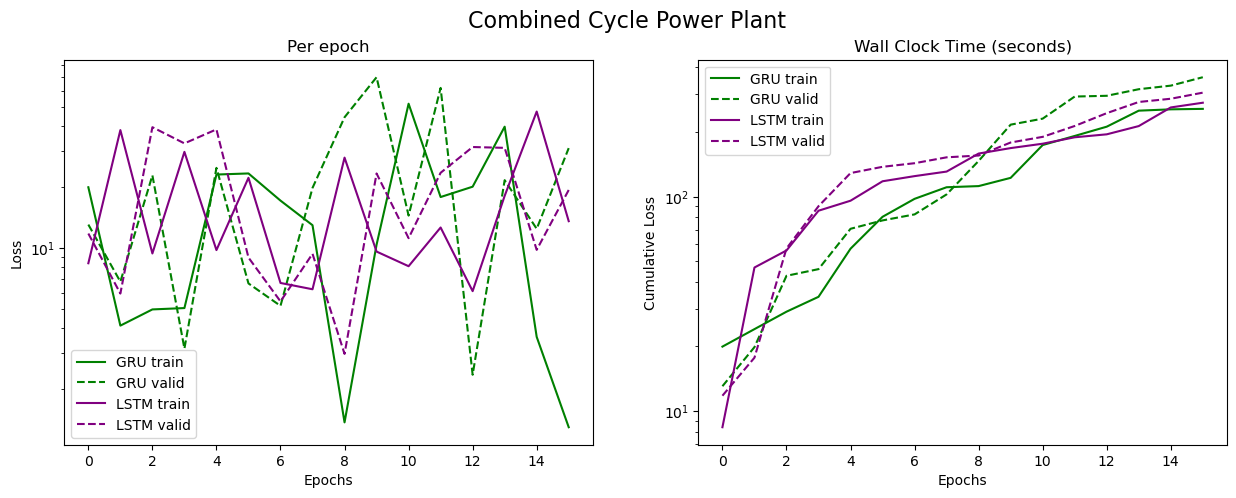

In [20]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(0, 16, 1)
loss_gru_train = np.random.lognormal(2.5, 1, size=16)
loss_gru_valid = np.random.lognormal(2.5, 1, size=16)
loss_lstm_train = np.random.lognormal(2.8, 1, size=16)
loss_lstm_valid = np.random.lognormal(2.8, 1, size=16)

# 누적 손실 (손실의 누적 합을 사용)
cumulative_loss_gru_train = np.cumsum(loss_gru_train)
cumulative_loss_gru_valid = np.cumsum(loss_gru_valid)
cumulative_loss_lstm_train = np.cumsum(loss_lstm_train)
cumulative_loss_lstm_valid = np.cumsum(loss_lstm_valid)

# 서브플롯 생성
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 그래프 1: 에포크별 손실
ax[0].plot(epochs, loss_gru_train, label='GRU train', color='green')
ax[0].plot(epochs, loss_gru_valid, '--', label='GRU valid', color='green')
ax[0].plot(epochs, loss_lstm_train, label='LSTM train', color='purple')
ax[0].plot(epochs, loss_lstm_valid, '--', label='LSTM valid', color='purple')
ax[0].set_yscale('log')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Per epoch')
ax[0].legend()

# 그래프 2: 에포크별 누적 손실
ax[1].plot(epochs, cumulative_loss_gru_train, label='GRU train', color='green')
ax[1].plot(epochs, cumulative_loss_gru_valid, '--', label='GRU valid', color='green')
ax[1].plot(epochs, cumulative_loss_lstm_train, label='LSTM train', color='purple')
ax[1].plot(epochs, cumulative_loss_lstm_valid, '--', label='LSTM valid', color='purple')
ax[1].set_yscale('log')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Cumulative Loss')
ax[1].set_title('Wall Clock Time (seconds)')
ax[1].legend()

# 전체 제목 설정
fig.suptitle('Combined Cycle Power Plant', fontsize=16)

# 그래프 출력
plt.show()

